In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
# Generujemy dane do późniejszej analizy
np.random.seed(42)

shape = (5, 1)
noise = np.round(np.random.randn(*shape) / 10, 2)
X = np.round(np.random.random(size=shape), 2)
a, b = 2, 3
y = a * X + b + noise

# Jeśli chcemy powtórzyć ćwiczenie dla jednego punktu
# X = np.array([[0.5]])
# y = np.array([[1]])

# sposób bardziej macierzowy 
# i = np.ones(shape)
# X = np.concatenate([X, i], axis=1)
# coef = np.array([[2.], [3.]])

# y = X.dot(coef) + noise

In [3]:
X

array([[0.06],
       [0.87],
       [0.6 ],
       [0.71],
       [0.02]])

In [4]:
y

array([[3.17],
       [4.73],
       [4.26],
       [4.57],
       [3.02]])

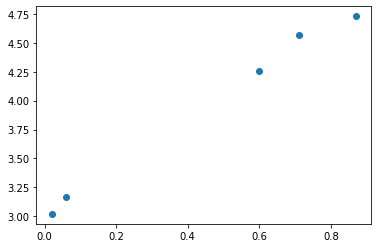

In [5]:
plt.scatter(X, y)
plt.show()

In [6]:
# czyszczenie sesji i ustawienie random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [7]:
# definicja modelu

# Model składa się z jdengo nuronu i funckji aktywacji: identyczność (g(x)=x)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=1, input_shape=(1,))
    ]
)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [9]:
# w momencie definicji modelu nastąpiła inicjalizacja wag, 
# dla ćwiczenia zmienimy wagi na ustalone przez nas

model.layers[0].set_weights([np.array([[0.1]]), np.array([0.])])

In [10]:
weights = model.layers[0].get_weights()
print(weights)
w1, w0 = weights[0][0], weights[1]
print(f"w1: {w1}\nw0: {w0}")

[array([[0.1]], dtype=float32), array([0.], dtype=float32)]
w1: [0.1]
w0: [0.]


In [11]:
# kiedny nasz sieć jest zdefiniowana a wagi ustalon możemy wykonać 
# wstępną predykcję na danych

y_init = model.predict(X[:, 0])

1/1 [==============================] - 0s 52ms/step


2022-11-17 19:00:33.401839: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
# dla przykadu pierwsza obserwacja jest liczona w ten sposób
print(y[0])
print(y_init[0])
print(f"w1*x1 + w0: {w1*X[0, 0] + w0}")

[3.17]
[0.006]
w1*x1 + w0: [0.006]


In [13]:
# ustalny learning rate 
learning_rate = 0.01 

# policzmy błąd średniokwadratowy przy użyciu tf
mse = tf.keras.losses.MeanSquaredError()
mse(y_init, y).numpy()

15.711533982442656

In [14]:
# ten sam rezultat dostaniemy licząc "ręcznie"
mse_ = np.mean((y_init - y) ** 2)
print(mse_)

15.711533982442656


$\frac{\partial E_{total}}{\partial w1}=\frac{\partial E_{total}}{\partial out_1}\times\frac{\partial out_1}{\partial net_1}\times\frac{\partial net_1}{\partial w_1}$

$E_{total}=mse=\left(target-out_1\right)^2$

$\frac{\partial E_{total}}{\partial out_1}=2*\left(target-out_1\right)^2\times(-1)$

$out_1=g(net_1)=net_1$

$\frac{\partial out_1}{\partial net_1}=1$

$net_1=w_1\times x_1+w_0$

$\frac{\partial net_1}{\partial w_1}=x_1$





<hr>

In [15]:
# pochodna cząstkow błędu po wyjściu z neuronu
error = (y_init - y) * 2
d_E_total = error
print("pochodna cząstkow błędu po wyjściu z neuronu")
print(error)
print()

d_out_1 = 1

d_net = X

# błąd "zależny" od wagi
d_E_total_w1 = np.mean(d_net * d_out_1 * d_E_total)
print('błąd "zależny" od wagi')
print(d_E_total_w1)

pochodna cząstkow błędu po wyjściu z neuronu
[[-6.328     ]
 [-9.28599999]
 [-8.4       ]
 [-8.998     ]
 [-6.036     ]]

błąd "zależny" od wagi
-4.001559997043983


In [16]:
# aktualizacja wagi w1
print("Nowa waga:")
w1_new = w1 - learning_rate * d_E_total_w1 
print(w1_new)

Nowa waga:
[0.1400156]


In [17]:
# całość należy powtórzyć dla wago w0
d_E_total_w0 = np.mean(d_E_total)
w0_new = w0 - learning_rate * d_E_total_w0 
w0_new

array([0.078096], dtype=float32)

<hr>

In [18]:
# Wykonajmy to samo przużyciu tensorflow
# na początku zdefiniujmy optimizer - SDG
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# nestępnie musimu skompilować model
model.compile(optimizer=optimizer,
              loss=mse)

In [19]:
# pamiętamy, że model był zdefiniowany wcześniej, 
# wagi zainicjalizowane (przez nas), 
# dzięki czemu możemy dokonać ewaluacji
# wynikiem będzie wartość straty

model.evaluate(X, y)

1/1 [==============================] - 0s 54ms/step - loss: 15.7115


15.71153450012207

In [20]:
# teraz musimy dokonać aktualizacji wag, czyli rozpocząć proces uczenia
# do tego służy metoda .fit
# w naszym przypadku chcemy dokonać tylko jednej aktualizacji, 
# stąd ustawimy ilość epok na 1.

model.fit(X, y, epochs=1)

1/1 [==============================] - 0s 107ms/step - loss: 15.7115


In [21]:
# zwróćmy uwagę na stratę - loss: 15.7115
# skoro model wykonał jeden krok to spodziewalibyśmy się, że się czegoś nauczył,
# a tu strata jest dokłądnie taka sama jak w przypadku wstępnej ewaluacji.
# Pamiętamy jednak, że proces uczenia sieci neuronowej 
# składa się z dwóch etapów - forward propagataion i backward propagation.
# Wartość straty jest po kazana po pierwszym kroku, forward propagation.
# Następnie wynkonywany jest proces bacwarrd propagation czyli następuje 
# aktualizacja wag. 
# Żeby sprawdzić bład po pierwszej epoce musimy dokonać ewaluacji jeszcze raz. 

In [22]:
# Jak widzimy błąd jest mniejszy/inny więc model sie czegoś nauczył.

model.evaluate(X, y)

1/1 [==============================] - 0s 8ms/step - loss: 14.9510


14.950956344604492

In [23]:
# dodatkowo sprawdźmy wagi:


new_layer = model.layers[0].get_weights()
new_layer

[array([[0.1400156]], dtype=float32), array([0.078096], dtype=float32)]

In [24]:
# tak samo jak poprzednio - Matematyka działa :) 